> ### EEE4423: Deep Learning Lab

# LAB \#6: Semantic Segmentation

<h4><div style="text-align: right"> Due date: April 15, 2022. </div> <br> 
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [Name_ID_lab6.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">[2018142102] [Euijin Hong]</span> </h2>

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-04-12 15:24:22.669077


In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1aR-RSJCsSEROjmQych61RbIhBul9cqA1" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates. 


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1l2-Degy7LpK20NbooHosRV8NzeRvNdPd" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

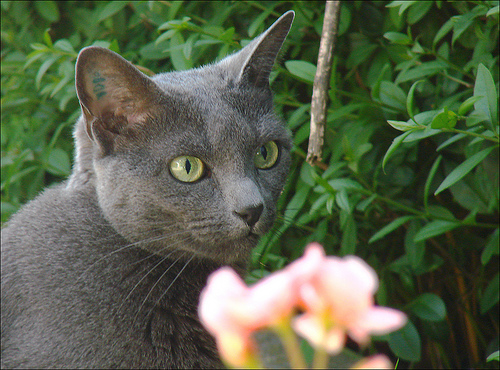

In [ ]:
from PIL import Image
test_img_path = './dataset-dllab/lab06/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [ ]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [ ]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

In [ ]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [ ]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [ ]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [ ]:
print(res)

tensor([[285., 285., 285.,  ..., 282., 285., 285.],
        [285., 285., 285.,  ..., 285., 285., 285.],
        [285., 285., 285.,  ...,  24., 285., 282.],
        ...,
        [299., 285., 360.,  ..., 254.,  31., 254.],
        [285., 285., 285.,  ..., 362., 281., 254.],
        [286., 286., 286.,  ..., 299., 254.,  89.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


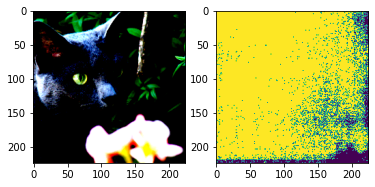

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1sWibO6xfau_kfWt-2T_rh_ARrzsR4PRV" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [ ]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)
        
        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)
        
        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [ ]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [ ]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [ ]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [ ]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[285, 285, 284, 284, 284, 284, 285, 285, 285],
         [284, 285, 285, 285, 284, 285, 285, 285, 285],
         [284, 284, 284, 284, 284, 284, 285, 285, 285],
         [284, 284, 284, 284, 284, 282, 285, 282, 282],
         [285, 285, 285, 285, 285, 285, 285, 285, 285]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [ ]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        #############
        # CODE HERE #
        #############
        
        # fully convolutional layer for predicting the segmentation classes
        self.fc8 = nn.Conv2d(4096, 21, 1)
        
        self.copy_params_from_vgg16()
        

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)
        
        score = self.fc8(fc7)
        
        #############
        # CODE HERE #
        #############
        
        # bilinear upsampling layer applied to the predicted output, upsampling to the original image size. 
        score = torch.nn.functional.interpolate(score, size=(x.size(2), x.size(3)), mode='bilinear')
        
        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [ ]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [ ]:
def decode_labels(mask, num_classes=21):
    from PIL import Image         
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        
    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [ ]:
model_data = torch.load('./pretrain/lab06/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


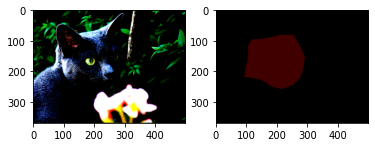

In [ ]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1IfoOAei35ydfeWu5qlXhZwNnW8cy_tJn"  onerror="this.style.display='none'" /><br><br>


- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1DCDuj_6IhA8HdZzE8OZkrYIuDeevtjKV"  onerror="this.style.display='none'" /><br><br>

- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters. 

## 2. [Lab] Semantic segmentation 

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1icsmWH1-N_g90VJOg7zyIFVec-TmPscA"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [ ]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())
    
# crop boundary 
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b 

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [ ]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        #############
        # CODE HERE #
        ############# 
        
        # prediction values for each class from feature map of layers: fc8, pool4, pool3, respectively
        self.predict1 = nn.Conv2d(4096, n_class, 1)
        self.predict2 = nn.Conv2d(512, n_class, 1)
        self.predict3 = nn.Conv2d(256, n_class, 1)
        
        # upsampling by deconvolution layers on combining the class-predicted outputs
        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)
        
        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)
        
        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        #############
        # CODE HERE #
        ############# 
        
        # image used for sizing the final crop
        image = x
        
        # pool3 and pool4 used for storing the extracted pooling layers
        pool3 = x
        pool4 = x
        
        # forward passing the vgg16 model until passing the pooling3 layer
        for i in range(31):
          pool3 = self.features[i](pool3)
          if i == 16:
            break
            
        # forward passing the vgg16 model until passing the pooling4 layer
        for i in range(31):
          pool4 = self.features[i](pool4)
          if i == 23:
            break

        # forwarding the input to the vgg16 fcn model
        x = self.features(x)
        x = self.relu6(self.fc6(x))
        x = self.drop6(x)
        x = self.relu7(self.fc7(x))
        x = self.drop7(x)
        
        # obtaining the class predicton score of fc8
        x = self.predict1(x)
        
        # upsampling the prediction output of fc8 by scale factor 2
        upscore2 = self.deconv1(x)
        
        # obtaining the class prediction score of pool4
        pool4 = self.predict2(pool4) 
        
        # cropping the pool4 class prediction output to the size of the upsampled fc8 prediction output
        x = pool4[:, :, 5:5+upscore2.size(2), 5:5+upscore2.size(3)]
        score_pool4c = x

        # add connecting the pool4 class prediction output with weight 0.01 and the upsampled fc8 prediction output
        x = upscore2 + score_pool4c * 0.01
        
        # upsampling the merged output of fc8 and pool4 by scale factor 2
        upscore_pool4 = self.deconv2(x)

        # obtaining the class prediction score of pool3
        pool3 = self.predict3(pool3)
        
        # cropping the pool3 class prediction output to the size of the upsampled fc8 + pool4 prediction output
        x = pool3[:, :, 9:9+upscore_pool4.size(2), 9:9+upscore_pool4.size(3)]
        score_pool3c = x
        
        # add connecting the pool3 class prediction output with weight 0.0001 and the upsampled fc8 prediction output
        x = upscore_pool4 + score_pool3c * 0.0001
        
        # upsampling the prediction output of fc8 + pool4 + pool3 by scale factor 8
        x = self.deconv3(x)
        
        # cropping the final class prediction output to the size of the input image
        x = x[:, :, 31:31+image.size(2), 31:31+image.size(3)].contiguous()
        
        return x

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))
            
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [ ]:
model = FCN8s().cuda()
model

FCN8s(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

**Data Loader functions**

In [ ]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='./dataset-dllab/lab06/gt', img_path='./dataset-dllab/lab06/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)
    
    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [ ]:
img_list = read_file('./dataset-dllab/lab06/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [ ]:
# selected the learning rate to 1e-5
lr = 1e-5   # choose your lr

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
max_iter = 30000 # iterating for 30000 cycles

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [ ]:
def loss_calc(out, label):
    #############
    # CODE HERE #
    ############# 
    
    # using cross-entropy loss as a loss function
    criterion = nn.CrossEntropyLoss()
    return criterion(out, label)

In [ ]:
running_loss = 0.0

# initialize the best loss value to 0.5
best_loss = 0.5

for iter in range(max_iter + 1):
    inputs, label = get_data(next(data_gen))
    
    #############
    # CODE HERE #
    ############# 
    # set the model to a training mode
    model.train()
    
    # convert the label to Tensor
    label= torch.Tensor(label) 
    
    # using GPU for both inputs and label, while converting the label datatype to int to match the datatype
    inputs, label=inputs.cuda(), label.type(torch.int64).cuda()
    
    # clear gradients with respect to parameters
    optimizer.zero_grad()
    
    # forward passing the FCN8s model
    out = model(inputs)
    
    # calculating loss with the defined function
    loss = loss_calc(out, label)
    running_loss += loss.data.item()
    
    # getting gradients with respect to parameters
    loss.backward()
    
    # update the parameters by optimizer
    optimizer.step()
    
    # printing the iteration number and the loss value for every 100 iteration
    if (iter % 100 == 0 and iter != 0):
        running_loss /= 100
        print(f'Iteration: {iter}, Loss: {running_loss}')
        # saving the model that shows the better result than the current best loss value, print and update the best loss
        if iter > 0 and best_loss > running_loss:
            best_loss = running_loss
            print(f"Best Loss: {best_loss}")
            torch.save(model, './weights/lab06/best.pt')
        running_loss = 0
        
# printing the final best loss
print(f"Best Loss: {best_loss}")

Iteration: 100, Loss: 2.865128077864647
Iteration: 200, Loss: 1.7162242867052555
Iteration: 300, Loss: 1.5638444910943508
Iteration: 400, Loss: 1.4450457680225373
Iteration: 500, Loss: 1.3914528368413448
Iteration: 600, Loss: 1.4141809949278832
Iteration: 700, Loss: 1.3546212484687568
Iteration: 800, Loss: 1.3486739076301455
Iteration: 900, Loss: 1.1535633355379105
Iteration: 1000, Loss: 1.2264931973069906
Iteration: 1100, Loss: 1.1379828153923155
Iteration: 1200, Loss: 1.256352168172598
Iteration: 1300, Loss: 1.146363516151905
Iteration: 1400, Loss: 1.0778305675461888
Iteration: 1500, Loss: 1.0478445237874985
Iteration: 1600, Loss: 0.98373466540128
Iteration: 1700, Loss: 1.0138034335151316
Iteration: 1800, Loss: 1.069170455262065
Iteration: 1900, Loss: 0.8394580038264394
Iteration: 2000, Loss: 1.0139253729209303
Iteration: 2100, Loss: 0.9305980861559511
Iteration: 2200, Loss: 0.9907272548414767
Iteration: 2300, Loss: 0.9669310567528009
Iteration: 2400, Loss: 0.948941766321659
Iteratio

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.47 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [ ]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))
    
    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)
    
    val_list = open('./dataset-dllab/lab06/list/val.txt').readlines()
    
    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('./dataset-dllab/lab06/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('./dataset-dllab/lab06/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))
        
    return np.sum(miou) / len(miou)

In [ ]:
#############
# CODE HERE #
############# 

# mIoU of model
fcn8s_miou= validation_miou(model)

# mIoU of the best model
best_model = torch.load('./weights/lab06/best.pt')
fcn8s_best_miou= validation_miou(best_model)

# mIoU of model in section 1.2.2
bilinearVgg_miou= validation_miou(conv_vgg_upsample)

1/1449 ...
2/1449 ...
3/1449 ...
4/1449 ...
5/1449 ...
6/1449 ...
7/1449 ...
8/1449 ...
9/1449 ...
10/1449 ...
11/1449 ...
12/1449 ...
13/1449 ...
14/1449 ...
15/1449 ...
16/1449 ...
17/1449 ...
18/1449 ...
19/1449 ...
20/1449 ...
21/1449 ...
22/1449 ...
23/1449 ...
24/1449 ...
25/1449 ...
26/1449 ...
27/1449 ...
28/1449 ...
29/1449 ...
30/1449 ...
31/1449 ...
32/1449 ...
33/1449 ...
34/1449 ...
35/1449 ...
36/1449 ...
37/1449 ...
38/1449 ...
39/1449 ...
40/1449 ...
41/1449 ...
42/1449 ...
43/1449 ...
44/1449 ...
45/1449 ...
46/1449 ...
47/1449 ...
48/1449 ...
49/1449 ...
50/1449 ...
51/1449 ...
52/1449 ...
53/1449 ...
54/1449 ...
55/1449 ...
56/1449 ...
57/1449 ...
58/1449 ...
59/1449 ...
60/1449 ...
61/1449 ...
62/1449 ...
63/1449 ...
64/1449 ...
65/1449 ...
66/1449 ...
67/1449 ...
68/1449 ...
69/1449 ...
70/1449 ...
71/1449 ...
72/1449 ...
73/1449 ...
74/1449 ...
75/1449 ...
76/1449 ...
77/1449 ...
78/1449 ...
79/1449 ...
80/1449 ...
81/1449 ...
82/1449 ...
83/1449 ...
84/1449 ...
8

In [ ]:
print('Mean IoU of model FCN-8s is:', fcn8s_miou)
print('Mean IoU of best model FCN-8s is:', fcn8s_best_miou)
print('Mean IoU of model bilinear upsampled VGG-16 is:', bilinearVgg_miou)

Mean IoU of model FCN-8s is: 0.4737666053135066
Mean IoU of best model FCN-8s is: 0.46616279018723084
Mean IoU of model bilinear upsampled VGG-16 is: 0.4384477684521856


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


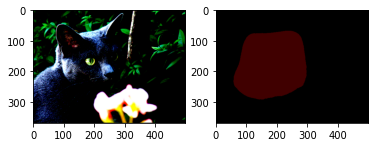

In [ ]:
# Visualize the result
#############
# CODE HERE #
############# 

# visualizing the prediction output of the vgg16 FCN8s model
with torch.no_grad():
    fcn_out = model(test_conv)
    fcn_output = torch.argmax(fcn_out, dim=1)

    vis_fcn_output = decode_labels(fcn_output[0].data.cpu().numpy())

    plt.subplot(1,2,1)
    plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
    plt.subplot(1,2,2)
    plt.imshow(vis_fcn_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


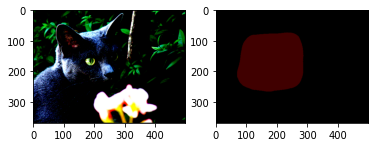

In [ ]:
# visualizing the prediction output of the vgg16 FCN8s best-loss model
with torch.no_grad():
    fcn_best_out = best_model(test_conv)
    fcn_best_output = torch.argmax(fcn_best_out, dim=1)

    vis_fcn_best_output = decode_labels(fcn_best_output[0].data.cpu().numpy())

    plt.subplot(1,2,1)
    plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
    plt.subplot(1,2,2)
    plt.imshow(vis_fcn_best_output)

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)

# Discussion

- 30000번의 iteration을 통해 최종적으로 학습 된 FCN-8s 모델과 bilinear upsampling 한 모델의 mIoU는 각각 0.474, 0.438이 나왔다. Loss가 가장 작은 FCN-8s 모델을 따로 저장하여 mIoU를 구했고, 이 값은 0.466이었다. 이를 통해 목표했던 mIoU 값이었던 0.47을 상회하는 결과를 얻을 수 있었다. 

- Inference result를 출력하여 본 결과, bilinear upsampling을 통해 얻을 수 있었던 semantic segmentation 결과도 나쁘지 않은 정확도를 보였지만, 물체의 경계를 더 정확하게 인식한 모델은 FCN-8s 모델들(최종으로 얻은 모델과 최소 loss 모델)이었다. 

- 위처럼 FCN-8s 모델이 성능이 더 좋게 나온 이유로는 크게  가지 정도를 생각할 수 있다. 
  - 첫째로는, VGG16의 각각 3번째와 4번째 pooling layer들을 통과하여 얻은 feature map들을 최종 추론된 output과 더함으로써 구체적인 appearance에 대한 정보를 학습하여 inference를 정교화시킬 수 있었기 때문이다. 그 이유는, layer의 깊이가 얕을수록 학습하는 channel의 개수는 적지만 더 넓은 feature map을 기반으로 학습할 수 있고, 이를 통해 물체의 테두리와 같은 자세한 위치 정보를 더욱 효과적으로 획득할 수 있기 때문이다. 이를 기존의 coarse하지만 semantic한 정보를 가지고 있는 fcn의 최종 inference output과 결합하여 상대적으로 더 명료한 추론 결과를 얻을 수 있었다. 
  - 둘째로는, bilinear upsampling을 시킬 때 한 번에 scaling factor가 약 32 정도 되는 비율로 upscaling을 시키는데, 이때 상당히 coarse한 fcn의 최종 추론 output이 그대로 확대되었기 때문에 경계와 외관 정보에 대한 정보가 상대적으로 불명확한 상태의 output이 획득된 것이다. 한편, FCN-8s에서는 이를 scaling factor 2씩 확대시키며 각각의 pooling layer output들과 더함으로써 위치 및 외관 정보의 손실을 줄이면서 이미지 크기를 확대시킬 수 있었다. 
  - 셋째로는, scored image를 upsampling하는 과정에서 bilinear upsampling 과는 다르게 deconvolution을 이용하였기에 정확도가 더 향상된 것으로 보인다. 이는 deconvolution layer들이 feature upsampling에 관련된 정보를 효과적으로 학습하기 때문이다. 

- Loss 값이 가장 작은 FCN-8s 모델은 최종 학습된 FCN-8s 모델보다 mIoU 값이 작게 나타났는데, 이는 해당 loss에서의 학습 결과가 train dataset에 대해 overfitting이 일어났기 때문이라고 생각한다. 반면 최종적으로 얻은 모델은 loss가 최소인 모델에 비해 새로운 데이터를 추론하기에 더 알맞은 형태로 학습이 된 것으로 볼 수 있다. 

- 20000번의 iteration을 돌렸을 적에는 mIoU가 0.440 내외로 나왔는데, iteration 수를 30000으로 늘렸더니 mIoU가 0.474로 나왔다는 것은 2만번의 iteration으로는 model이 불충분하게 학습되었던 것으로 보인다. 

- FCN-8s의 learning rate는 1e-5로 설정해 주었는데, 1e-4, 1e-6 등의 learning rate들과 비교했을 때, 1e-5 learning rate에서 loss값이 가장 빠르고 명확하게 감소하며 converging이 매우 잘 일어나는 것을 확인할 수 있었고, mIoU도 가장 잘 나오는 것으로 확인되었다. 고정된 learning rate을 이용할 경우에는 1e-5가 가장 optimal한 값임을 알 수 있었다. 
